In [7]:
%tensorflow_version 2.1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import layers

In [9]:
# Print versions
!python --versions
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

Unknown option: --
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.
Numpy 1.18.5
TensorFlow 2.3.0
Keras 2.4.0


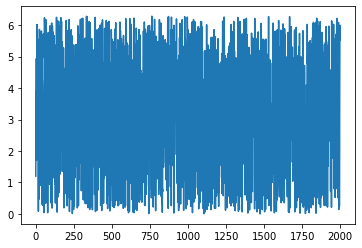

In [24]:
# Number of samples to use as a dataset
nsamples = 2000    
# Percentage of samples of validation set
val_ratio = 0.2     
# Percentage of samples of test set
test_ratio = 0.2  
# Will be given .tflite suffix
tflite_model_name = 'sine_model'  
# Will be given .h suffix
c_model_name = 'sine_model' 

# Generate some random samples
# All the random numbers generated after setting particular seed value are same across all the platforms/systems.
np.random.seed(1234)
# Generate samples between [0, 2pi]
x_values = np.random.uniform(low=0, high=(2 * math.pi), size=nsamples)
# Print x_values 
plt.plot(x_values)

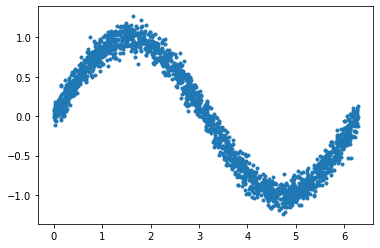

In [25]:
# Create sine wave with noise
y_values = np.sin(x_values) + (0.1 * np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')

In [26]:
# Split the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

In [27]:
# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples

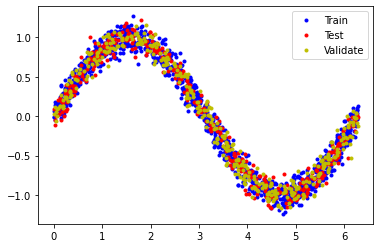

In [28]:
# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

In [29]:
# Create a model with 3-layer, fully-connected (dense) neural network
model = tf.keras.Sequential()
# Layer 1
model.add(layers.Dense(16, activation='relu', input_shape=(1,))) 
# Layer 2
model.add(layers.Dense(16, activation='relu'))
# Layer 3
model.add(layers.Dense(1))
# View model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

# Train model
history = model.fit(x_train,y_train,epochs=500,batch_size=100,validation_data=(x_val, y_val))

Epoch 1/500
12/12 [==============================] - 0s 10ms/step - loss: 0.7069 - mae: 0.7069 - val_loss: 0.6323 - val_mae: 0.6323
Epoch 2/500
12/12 [==============================] - 0s 3ms/step - loss: 0.6066 - mae: 0.6066 - val_loss: 0.5529 - val_mae: 0.5529
Epoch 3/500
12/12 [==============================] - 0s 2ms/step - loss: 0.5551 - mae: 0.5551 - val_loss: 0.5151 - val_mae: 0.5151
Epoch 4/500
12/12 [==============================] - 0s 2ms/step - loss: 0.5250 - mae: 0.5250 - val_loss: 0.4885 - val_mae: 0.4885
Epoch 5/500
12/12 [==============================] - 0s 2ms/step - loss: 0.4937 - mae: 0.4937 - val_loss: 0.4613 - val_mae: 0.4613
Epoch 6/500
12/12 [==============================] - 0s 2ms/step - loss: 0.4687 - mae: 0.4687 - val_loss: 0.4470 - val_mae: 0.4470
Epoch 7/500
12/12 [==============================] - 0s 2ms/step - loss: 0.4513 - mae: 0.4513 - val_loss: 0.4316 - val_mae: 0.4316
Epoch 8/500
12/12 [==============================] - 0s 2ms/step - loss: 0.4334 - 

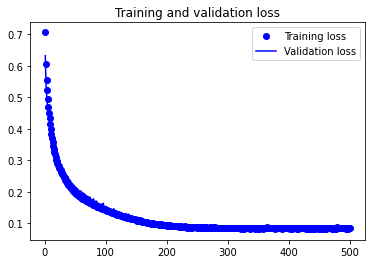

In [31]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

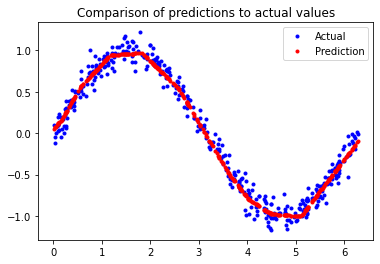

In [32]:


# Plot predictions against actual values
predictions = model.predict(x_test)

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Prediction')
plt.legend()
plt.show()



In [33]:
# Convert Keras model to a tflite (TensorFlow Lite) model file (stored as a FlatBuffer)
# that our microcontroller can use it 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp6_5lo0mj/assets


2928

In [35]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [36]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))